In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [57]:
df = pd.read_csv('/content/drive/MyDrive/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [58]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [60]:
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [61]:
df['total_bedrooms'] = df.groupby('ocean_proximity')['total_bedrooms'].transform(lambda x: x.fillna(x.median()))

**Outlier Detection**

In [62]:
num_cols = df.select_dtypes(include=['int64','float64'])
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (num_cols < lower_bound) | (num_cols > upper_bound)
df= df[~outliers.any(axis=1)]

In [63]:
df = pd.get_dummies(df)
bool_cats = df.select_dtypes(include='bool').columns

In [64]:
df[bool_cats] = df[bool_cats].astype(int)

In [65]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['population_per_household'] = df['population'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']

In [66]:
num_cols = df.select_dtypes(include=['int64','float64'])
corr_matrix = num_cols.corr()

/tmp/ipython-input-67-1449756410.py:17: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


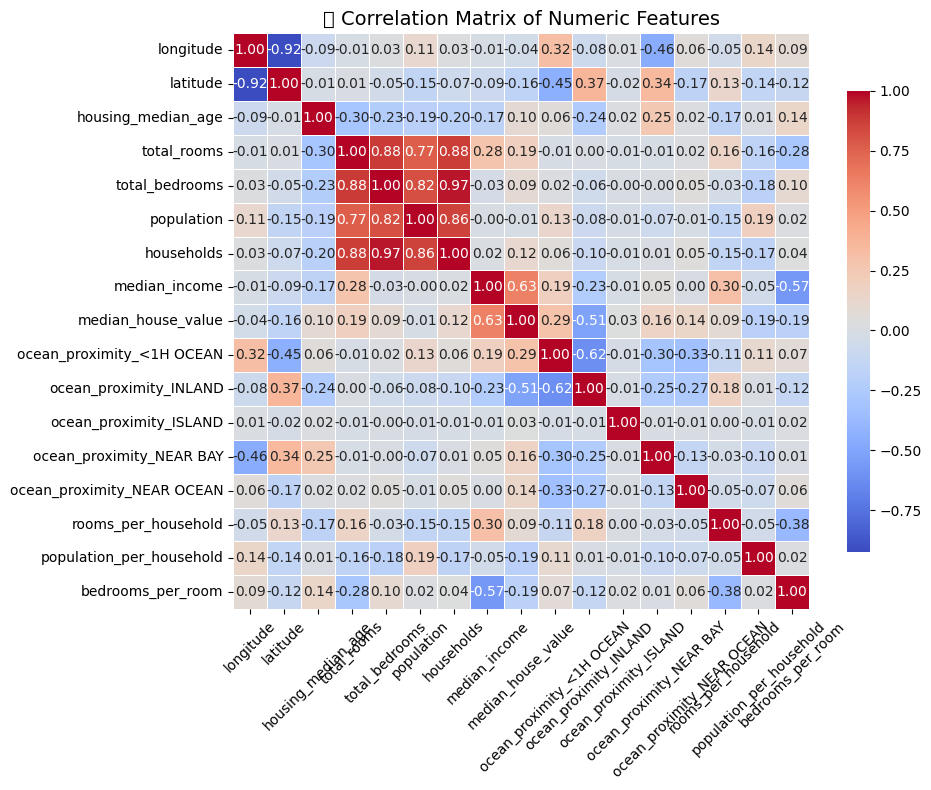

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,            # Show actual correlation values
    fmt=".2f",             # Format to 2 decimal places
    cmap='coolwarm',       # Color gradient (blue-red)
    square=True,           # Square cells
    linewidths=0.5,        # Lines between boxes
    cbar_kws={'shrink': 0.8},  # Color bar size
)
plt.title("🔗 Correlation Matrix of Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [68]:
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import train_test_split

In [69]:
x = df.drop('median_house_value',axis=1)
y = df['median_house_value']
target  = 'median_house_value'
select = SelectKBest(score_func=f_regression,k=12)
x_new = select.fit_transform(x,y)
selected_feature = x.columns[select.get_support()]

In [70]:
df_selected = df[selected_feature.to_list() + [target]]
x = df_selected.drop(columns=[target])
y = df_selected[target]

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [72]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)
model.fit(x_train,y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, random_state=42)

In [73]:
y_pred = model.predict(x_test)

In [74]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [75]:
print(f'MSE : {mean_squared_error(y_test,y_pred)}')
print(f'r2_score : {r2_score(y_test,y_pred)}')
print(f'MBE : {mean_absolute_error(y_test,y_pred)}')

MSE : 2671284726.569715
r2_score : 0.7080242268186778
MBE : 36748.08337760466


**Running Model again After using RandomSearch**

In [76]:
model = RandomForestRegressor(
    bootstrap=False,
    max_depth=20,
    max_features='log2',
    min_samples_leaf=2,
    n_estimators=500,
    random_state=42
)
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                      min_samples_leaf=2, n_estimators=500, random_state=42)

In [77]:
y_pred = model.predict(x_test)

In [78]:
print(f'MSE : {mean_squared_error(y_test,y_pred)}')
print(f'r2_score : {r2_score(y_test,y_pred)}')
print(f'MBE : {mean_absolute_error(y_test,y_pred)}')

MSE : 2365123679.313285
r2_score : 0.7414881281398562
MBE : 33539.07321685843


**RandomSearchInitialiZation**

In [79]:
# from sklearn.model_selection import RandomizedSearchCV

In [80]:
# param_dist = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [5, 10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

In [81]:
# rf = RandomForestRegressor(random_state=42)

# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=50,
#     cv=5,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42,
#     scoring='neg_root_mean_squared_error'  # For regression
# )

In [82]:
# random_search.fit(x_train, y_train)

In [83]:
# print("✅ Best Parameters Found:")
# print(random_search.best_params_)

# best_model = random_search.best_estimator_

# # Predict and evaluate
# y_pred = best_model.predict(x_test)
# rmse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"\n📊 RMSE: {rmse:.2f}")
# print(f"📈 R² Score: {r2:.4f}")
